<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - An Automated System for Accident Severity

> Author: Irfan Muzafar (DSI-42)
---

**Problem Statement:**  
How can we develop an automated system capable of analysing images from traffic cameras or phone cameras to classify accidents into four severity classes accurately?

There are a total of three notebooks for this project:  
 1. `01_Data_Cleaning_EDA.ipynb`   
 2. `02_CNN_Pretrained_Models.ipynb`   
 3. `03_Evaluation_Conclusion.ipynb`

Image dataset: [`Car Crash Severity Detection`](https://universe.roboflow.com/ansonlau1325-gmail-com/car-crash-severity-detection/dataset/13)

**This Notebook**
- Fit our image dataset into self-trained Convolutional Neural Network (CNN) model. 
- Fit our image dataset into some pre-trained models.
- Evaluate accuracy and loss for each model.

# **Part 2 - Modelling**

# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential # Sequential class to sequentially build the model step-by-step
from tensorflow.keras.optimizers import Adam # Adam optimizer can still be used for CNNs

# Dense: fully connected layers for NNs model
# Flatten: to apply flattening (vector transformation)
# Convolution imports: Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras import utils

In [2]:
# Set a random seed
np.random.seed(42)

keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# 2. Generate DataFrame using directory

In [3]:
# Generate data paths with labels
data_dir = '../datasets/severity_acc'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

# 3. Train Test Split

In [4]:
# Splitting data into train-test sets
train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True)

In [5]:
train_df

,filepaths,labels
239,../datasets/severity_acc\moderate\images_053_j...,moderate
445,../datasets/severity_acc\no_acc\00170_jpg.rf.8...,no_acc
333,../datasets/severity_acc\no_acc\00053_jpg.rf.8...,no_acc
292,../datasets/severity_acc\no_acc\00012_jpg.rf.9...,no_acc
628,../datasets/severity_acc\no_acc\59_jpg.rf.c256...,no_acc
...,...,...
71,../datasets/severity_acc\fire\images_233--4-_j...,fire
106,../datasets/severity_acc\minor\images--1-_jpg....,minor
270,../datasets/severity_acc\moderate\images_551--...,moderate
435,../datasets/severity_acc\no_acc\00160_jpg.rf.e...,no_acc


In [6]:
valid_df

,filepaths,labels
247,../datasets/severity_acc\moderate\images_060_j...,moderate
575,../datasets/severity_acc\no_acc\194_jpg.rf.ab9...,no_acc
227,../datasets/severity_acc\moderate\images_039--...,moderate
290,../datasets/severity_acc\no_acc\00010_jpg.rf.2...,no_acc
538,../datasets/severity_acc\no_acc\160_jpg.rf.eaa...,no_acc
...,...,...
675,../datasets/severity_acc\severe\images_034_jpg...,severe
439,../datasets/severity_acc\no_acc\00164_jpg.rf.9...,no_acc
755,../datasets/severity_acc\severe\images_578_jpg...,severe
517,../datasets/severity_acc\no_acc\141_jpg.rf.f9e...,no_acc


In [7]:
train_df.to_csv('../datasets/train_df.csv', index=False)
valid_df.to_csv('../datasets/valid_df.csv', index=False)

# 4. Pre-processing data

In [66]:
# cropped image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = valid_gen.flow_from_dataframe(valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

Found 647 validated image filenames belonging to 5 classes.
Found 163 validated image filenames belonging to 5 classes.


c:\Users\muzaf\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [67]:
class_mappings = train_gen.class_indices # save output mappings dictionary to 'class_mappings' variable to use later for predictions
print(class_mappings) # shows us the 5 categories

{'fire': 0, 'minor': 1, 'moderate': 2, 'no_acc': 3, 'severe': 4}


In [68]:
# class count
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
class_count

5

In [69]:
classes = list(train_gen.class_indices.keys())
classes

['fire', 'minor', 'moderate', 'no_acc', 'severe']

# 5. Fit into various models

From here, we will fit our data into various models. We will first self train a Convolutional Neural Network (CNN) model. Since this is an image classification, CNN is appropriate for this problem.

### 5.1 CNN Model

In [70]:
# Instantiate a CNN model.
cnn_model = Sequential() # instantiating an empty model of Sequential class

# Add a convolutional layer to the instantiated empty model.
# Conv2D for 2-D convolution on image
cnn_model.add(Conv2D(filters=20,          # number of filters 
                     kernel_size=(3, 3),  # height/width of filter
                     padding='same',      # Ensure Output is same shape as Input
                     activation='relu',   # most popular activation function choice for convolution layers
                     input_shape=(224, 224, 3))) # shape of input (image)

# EVERY convolution layer is followed by a pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # dimensions of region of pooling

# Add another Conv2D and pooling layers
# this time we use 10 filters
cnn_model.add(Conv2D(filters=10,
                     kernel_size = (3, 3), # same as above
                     padding='same', # same as above
                     activation='relu')) # same as above

cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # dimensions of region of pooling (same as above pooling)

# Flatten added after MaxPooling2D operates to flatten n-dimensional array into 1-D vector
cnn_model.add(Flatten())

# Add some fully connected layers once we have 1-D vector from 'Flatten()'
cnn_model.add(Dense(128, activation='relu')) # 1 hidden layer with 128 nodes, relu activation
cnn_model.add(Dense(5, activation='softmax')) # output layer, 5 nodes, softmax activation for multi-classification

# Check out the model summary to confirm all our additions so far.
cnn_model.summary()

c:\Users\muzaf\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 10)   │         1,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 31360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     4,014,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,017,223 (15.32 MB)

 Trainable params: 4,017,223 (15.32 MB)

 Non-trainable params: 0 (0.00 B)

The convolution layer is where we pass a **filter** over an image.. Specifically, we take pixels that are close to one another, then summarize them with one number. The **aim of the convolution layer is to identify important features in the images, like edges**. The number of filters can be adjusted, but for now we use `filters=20` as a starting point. For `kernel_size`, 3 x 3 filter is generally the most widely used option. `padding='same'` is to ensure that the output image size is the same as input.

The MaxPooling2D layer reduces the data dimensionality by reducing the image size.

In [71]:
opt = Adam(learning_rate=0.001) # create an optimizer using Adam with learning rate 0.001
cnn_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy']) 
# compile model with 'categorical_crossentropy' loss, Adam optimizer & measure accuracy

We use 'categorical_crossentropy' as our loss function because our problem is a multi class classification. For simplicity, we will use accuracy as our metric. Other metrics may be too complicated for our image classification which has five classes.

In [72]:
# Fit model on training data (fit model and save results to history)
history = cnn_model.fit(train_gen, # train_data created using ImageDataGenerator class for model training
                        batch_size=16, # hyperparameter to tune
                        validation_data=valid_gen, # valid_gen created using ImageDataGenerator class for model valid
                        epochs=10)

Epoch 1/10


c:\Users\muzaf\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.3649 - loss: 2.4242 - val_accuracy: 0.5215 - val_loss: 1.2528
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.5285 - loss: 1.1519 - val_accuracy: 0.5521 - val_loss: 1.1850
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.7943 - loss: 0.6411 - val_accuracy: 0.6258 - val_loss: 1.0202
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.9182 - loss: 0.3440 - val_accuracy: 0.6012 - val_loss: 1.2789
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.9805 - loss: 0.1276 - val_accuracy: 0.6258 - val_loss: 1.1750
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9968 - loss: 0.0519 - val_accuracy: 0.6319 - val_loss: 1.3901
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.9928 - loss: 0.0820 - val_accuracy: 0.6258 - val_loss: 1.5803
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9941 - loss: 0.0546 - val_accuracy: 0.6258 - 

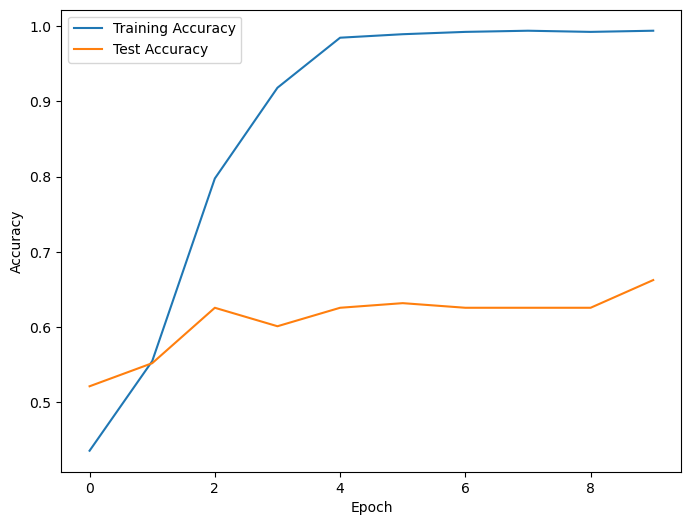

In [74]:
# Plot our train accuracy and test accuracy over epochs.
train_acc_cnn = history.history['accuracy']
test_acc_cnn = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing accuracy over the 10 epochs.
plt.plot(train_acc_cnn, label='Training Accuracy')
plt.plot(test_acc_cnn, label='Test Accuracy')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

From the accuracy plot, we observe that the training accuracy gets very high (close to 1) and the test accuracy increases to around 0.66 at epoch=10. This means that there is overfitting as the training accuracy is about 0.3 larger than the test accuracy.

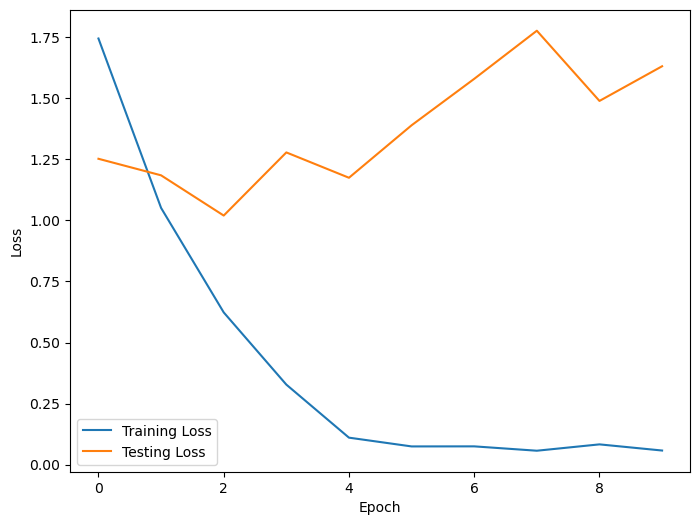

In [75]:
# Plot our train loss and test loss over epochs.
train_loss_cnn = history.history['loss']
test_loss_cnn = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over the 10 epochs.
plt.plot(train_loss_cnn, label='Training Loss')
plt.plot(test_loss_cnn, label='Testing Loss')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

We can infer from the above loss plot that the training loss continues to drop with increasing epochs, while the testing loss varies a lot. This is a bad sign as the test loss increases at some epochs.

In [77]:
# save cnn model
cnn_model.save("severity_cnn.h5")

We can save this CNN model as a h5 file, which will be used in the next notebook for predicting unseen data.

### 5.2 MobileNetV2 Pre-trained Model

We need to download the weights of the model that was already pre-trained by Google by creating an object of the MobileNetV2 class (to use the MobileNetV2 model) with these arguments: 
- `include_top=False` to exclude the classification head from the pre-trained model, because the MobileNetV2 model was trained on Imagenet dataset with 1,000 classes. Here we only have 5 classes. We use our own dense output layer for the multi classification at the output layer.
- `pooling=avg`: the final layer of MobileNetV2 is not a flattened layer, it is a **Global Pooling Layer**. We want to use global _average_ pooling. This is the pooling strategy applied to the final layer from the pre-trained model to convert the 2-D array into a 1-D vector. 

In [78]:
# Import the desired pre-trained transfer learning model: we'll use MobileNetV2
mobilenetv2 = MobileNetV2(include_top=False, pooling='avg')

# Freeze the model so we don't accidentally change the pre-trained model parameters during dense layer gradient descent
mobilenetv2.trainable = False

C:\Users\muzaf\AppData\Local\Temp\ipykernel_3296\1139867120.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2 = MobileNetV2(include_top=False, pooling='avg')


`mobilenetv2.trainable = False` ensures that during model training (gradient descent process), we don't change the weights of the pre-trained model, because this pre-trained model that we're using has already been trained and optimized for Imagenet data by Google and we want to avoid making any changes to its weights. We just want to use the CNN architecture from the pre-trained model as a feature extractor to give us a 1D vector at its output, that we will use as input to our own Neural Network classification head.

In [79]:
# Create our FNN model architecture
mn_model = Sequential() # instantiate empty sequential model using Sequential class

# Then add the pre-trained model to use Transfer Learning, get all the weights from pre_trained_model
mn_model.add(mobilenetv2) 

# Finally add our custom modifications - here, we'll just take the 1D vector output from MobileNetV2
mn_model.add(Dense(5, activation='softmax')) # dense 1 layer & activation = 'softmax' for categorical classification

mn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

From `summary()`, the first layer is entire model with multiple layers inside. There are 2.2 million parameters.

In [80]:
# Compile the model
opt = Adam(learning_rate=0.001) # specify Adam optimizer
mn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # specify loss function and metric

We use 'categorical_crossentropy' as our loss function because our problem is a multi class classification. For simplicity, we will use accuracy as our metric. Other metrics may be too complicated for our image classification which has five classes.

In [81]:
# Fit model on training data (fit model and save results to history)
history_mn = mn_model.fit(train_gen, # train_data created using ImageDataGenerator class for model training
                        batch_size=16, # hyperparameter to tune
                        validation_data=valid_gen, # val_data created using ImageDataGenerator class for model valid
                        epochs=5, # generally less than 5 is sufficient when using transfer learning!
                       )

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 423ms/step - accuracy: 0.5256 - loss: 1.3060 - val_accuracy: 0.7730 - val_loss: 0.5968
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - accuracy: 0.8189 - loss: 0.5076 - val_accuracy: 0.8037 - val_loss: 0.5129
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.8703 - loss: 0.3670 - val_accuracy: 0.7914 - val_loss: 0.4991
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step - accuracy: 0.9169 - loss: 0.2819 - val_accuracy: 0.8098 - val_loss: 0.4482
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - accuracy: 0.9392 - loss: 0.2255 - val_accuracy: 0.8098 - val_loss: 0.5140


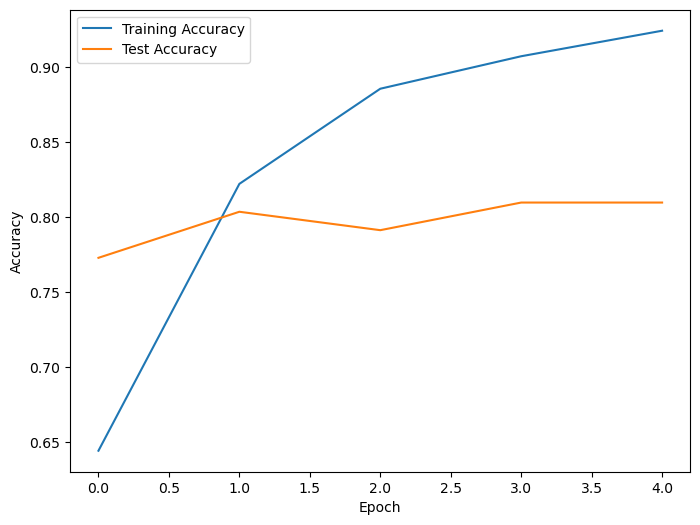

In [82]:
# Plot our train accuracy and test accuracy over epochs.
train_acc_mn = history_mn.history['accuracy']
test_acc_mn = history_mn.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing accuracy over the 5 epochs.
plt.plot(train_acc_mn, label='Training Accuracy')
plt.plot(test_acc_mn, label='Test Accuracy')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

From the accuracy plot, we observe that the training accuracy gets very high (close to 1) and the test accuracy increases to around 0.8 at epoch=5. This means that there is overfitting as the training accuracy is about 0.13 larger than the test accuracy. However, the overfitting is smaller compared to the CNN model we built earlier.

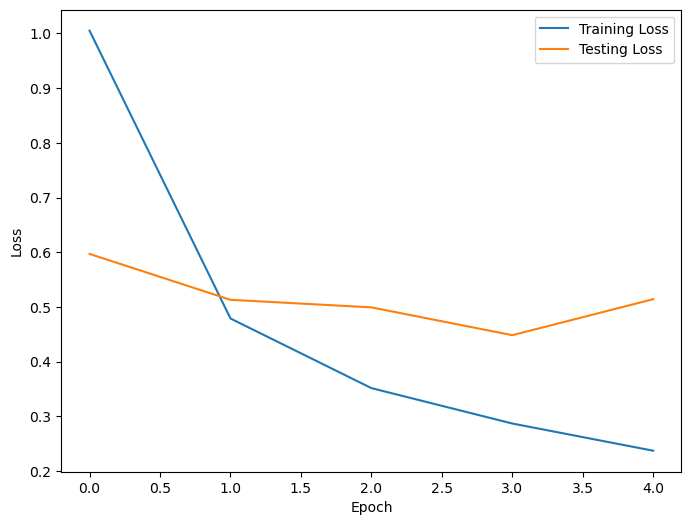

In [83]:
# Plot our train loss and test loss over epochs.
train_loss_mn = history_mn.history['loss']
test_loss_mn = history_mn.history['val_loss']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over the 5 epochs.
plt.plot(train_loss_mn, label='Training Loss')
plt.plot(test_loss_mn, label='Testing Loss')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

We can infer from the above loss plot that the training loss continues to drop with increasing epochs, while the testing loss drops until epoch=3, where it began to increase again. This is also a sign of overfitting. However, the gap between the train loss and test loss for MobileNetV2 is smaller than that for CNN.

In [84]:
# step 1: Save the model
mn_model.save('severity_mnv2.keras') # 'severity_mnv2' is the name of the trained model

We can save this MobileNetV2 model as a keras file, which will be used in the next notebook for predicting unseen data.

### 5.3 VGG19 Pre-trained Model

Next, we will explore using VGG19 Pre-trained Model with these arguments: 
- `include_top=True` to include the three fully connected layers at the top of the network.
- `vgg19.trainable = False` ensures that during model training (gradient descent process), we don't change the weights of the pre-trained model, because this pre-trained model that we're using has already been trained and optimized.

We will also replace the output layer (which is the last fully connected layer containing 1000 neurons) with our own dense output layer containing 5 neurons.

In [85]:
vgg19 = VGG19(include_top = True, weights="imagenet")
vgg19.trainable = False

fc2 =  vgg19.get_layer('fc2').output
predictions = Dense(5, activation='softmax')(fc2)  # replace output layer with 5 nodes for multi classification

vgg_model = Model(inputs=vgg19.input, outputs=predictions)
vgg_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 139,590,725 (532.50 MB)

 Trainable params: 20,485 (80.02 KB)

 Non-trainable params: 139,570,240 (532.42 MB)

From `summary()`, the layers in VGG19 is made up of an input layer, many Conv2D layers, some MaxPooling2D layers, a Flatten layer and two fully connected layers before the output layer. The total number of parameters is 139 million. Since we set `pre_trained_model.trainable = False` earlier, most of these parameters are not trainable parameters, and hence we notice in the summary output the value for `Trainable params: 20,485`, which are only the parameters of our final dense layer. 

In [86]:
opt = Adam(learning_rate=0.001) # specify Adam optimizer
vgg_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # loss function and metric

We use 'categorical_crossentropy' as our loss function because our problem is a multi class classification. For simplicity, we will use accuracy as our metric. Other metrics may be too complicated for our image classification which has five classes.

In [87]:
# Fit model on training data (fit model and save results to history)
history_vgg = vgg_model.fit(train_gen, # train_data created using ImageDataGenerator class for model training
                        batch_size=16, # hyperparameter to tune
                        validation_data=valid_gen, # valid_gen created using ImageDataGenerator class for model val
                        epochs=5, # generally less than 5 is sufficient when using transfer learning!
                       )

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.4577 - loss: 1.4873 - val_accuracy: 0.6258 - val_loss: 1.0173
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 218s 5s/step - accuracy: 0.6953 - loss: 0.7898 - val_accuracy: 0.6933 - val_loss: 0.7380
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.7454 - loss: 0.6759 - val_accuracy: 0.7791 - val_loss: 0.6474
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 191s 5s/step - accuracy: 0.7841 - loss: 0.5850 - val_accuracy: 0.7117 - val_loss: 0.7939
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 849s 21s/step - accuracy: 0.7710 - loss: 0.5937 - val_accuracy: 0.6687 - val_loss: 0.8421


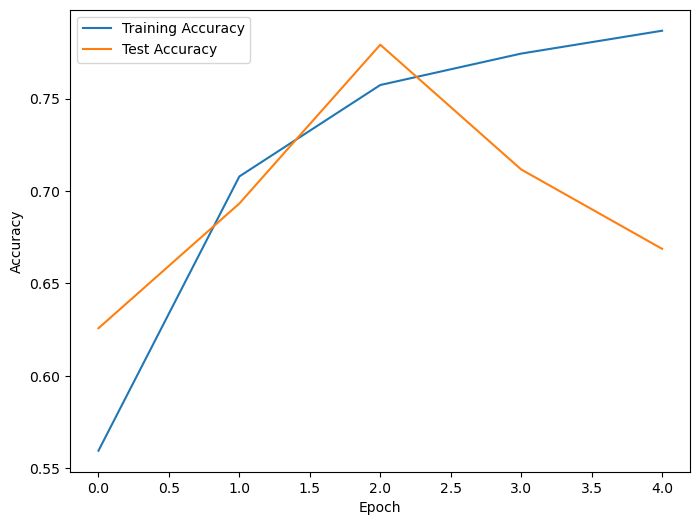

In [88]:
# Plot our train accuracy and test accuracy over epochs.
train_acc_vgg = history_vgg.history['accuracy']
test_acc_vgg = history_vgg.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing accuracy over the 5 epochs.
plt.plot(train_acc_vgg, label='Training Accuracy')
plt.plot(test_acc_vgg, label='Test Accuracy')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

From the accuracy plot, we observe that the training accuracy gets very high (close to 0.8) and the test accuracy increases to around 0.8 at epoch=2, then drops to 0.66. This means that there is overfitting as the training accuracy is about 0.1 larger than the test accuracy. However, the overfitting is smaller compared to the CNN model and the MobileNetV2 model we built earlier.


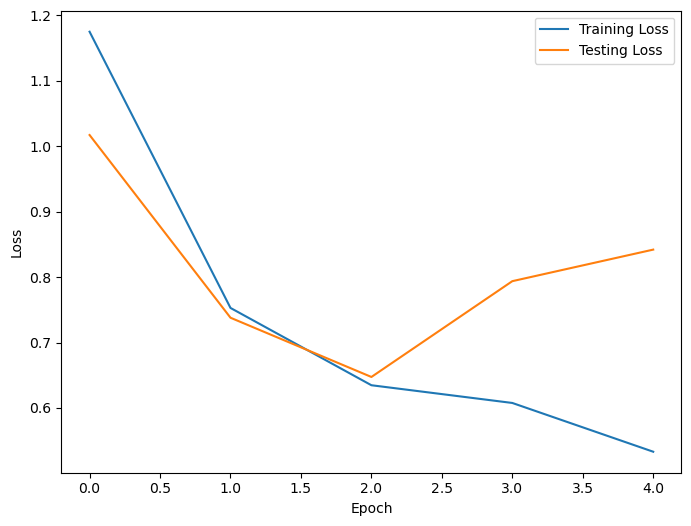

In [89]:
# Plot our train loss and test loss over epochs.
train_loss_vgg = history_vgg.history['loss']
test_loss_vgg = history_vgg.history['val_loss']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over the 5 epochs.
plt.plot(train_loss_vgg, label='Training Loss')
plt.plot(test_loss_vgg, label='Testing Loss')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

We can infer from the above loss plot that the training loss continues to drop with increasing epochs, while the testing loss drops until epoch=2, where it began to increase again. This is also a sign of overfitting. However, the gap between the train loss and test loss for VGG19 is smaller than that for CNN and MobileNetV2.


In [90]:
# Save the model
vgg_model.save('severity_vgg.h5') # 'severity_vgg' is the name of the trained model

We can save this VGG19 model as a h5 file, which will be used in the next notebook for predicting unseen data.

### 5.4 EfficientNetB4 Pre-trained Model

Next, we will explore using EfficientNetB4 Pre-trained Model with these arguments: 
- `include_top=False` to exclude the fully connected layer at the top of the network.
- `efn.trainable = False` ensures that during model training (gradient descent process), we don't change the weights of the pre-trained model, because this pre-trained model that we're using has already been trained and optimized.

We will also include our own dense output layer containing 5 neurons.

In [91]:
efn = EfficientNetB4(include_top = False, weights="imagenet")
efn.trainable = False

In [92]:
# Create our FNN model architecture
efn_model = Sequential() # instantiate empty sequential model using Sequential class

# Then add the pre-trained model to use Transfer Learning, get all the weights from pre_trained_model
efn_model.add(efn) 

efn_model.add(Flatten())

# Finally add our custom modifications - here, we'll just take the 1D vector output from MobileNetV2
efn_model.add(Dense(5, activation='softmax')) # dense 1 layer & activation = 'softmax' for categorical classification

efn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ ?                      │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

From [Architecture of all EfficientNet Models](https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142), the layers in EfficientNetB4 is made up of an input layer, many Conv2D layers, some BatchNormalization layers, some ZeroPadding layers and some Activation layers before the output layer. The total number of parameters is 64 million. Since we set `pre_trained_model.trainable = False` earlier, all of these parameters are not trainable parameters.

In [93]:
opt = Adam(learning_rate=0.001) # specify Adam optimizer
efn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # loss function and metric

We use 'categorical_crossentropy' as our loss function because our problem is a multi class classification. For simplicity, we will use accuracy as our metric. Other metrics may be too complicated for our image classification which has five classes.

In [94]:
# Fit model on training data (fit model and save results to history)
history_efn = efn_model.fit(train_gen, # train_data created using ImageDataGenerator class for model training
                        batch_size=16, # hyperparameter to tune
                        validation_data=valid_gen, # valid_gen created using ImageDataGenerator class for model val
                        epochs=5, # generally less than 5 is sufficient when using transfer learning!
                       )

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.2821 - loss: 16.6623 - val_accuracy: 0.2638 - val_loss: 7.3050
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3040 - loss: 4.6901 - val_accuracy: 0.3804 - val_loss: 3.2529
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.2608 - loss: 5.0826 - val_accuracy: 0.4663 - val_loss: 3.6434
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3093 - loss: 4.0529 - val_accuracy: 0.4663 - val_loss: 4.8414
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.2881 - loss: 3.9087 - val_accuracy: 0.4601 - val_loss: 5.2880


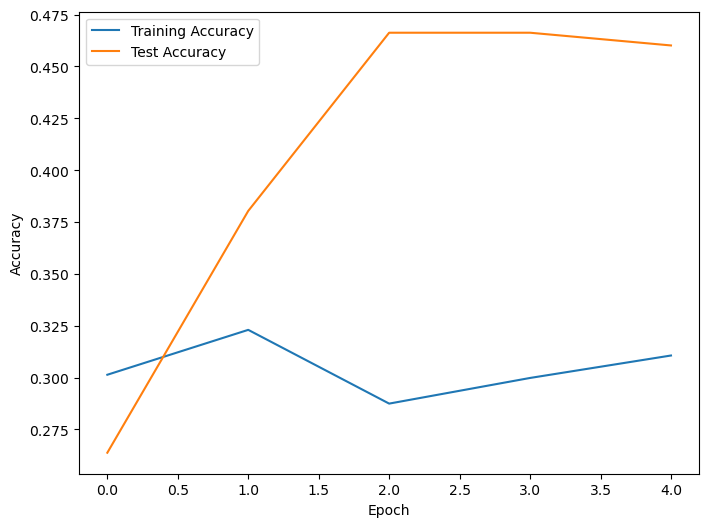

In [95]:
# Plot our train accuracy and test accuracy over epochs.
train_acc_efn = history_efn.history['accuracy']
test_acc_efn = history_efn.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing accuracy over the 5 epochs.
plt.plot(train_acc_efn, label='Training Accuracy')
plt.plot(test_acc_efn, label='Test Accuracy')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

From the accuracy plot, we observe that the training accuracy gets to a value of around 0.45 and the test accuracy varies and reaches a value of around 0.3 at epoch=4. The accuracies for both are below 0.5, which means that this EfficientNetB4 model is bad for predicting our data. Also, there is overfitting as the training accuracy is about 0.15 larger than the test accuracy.

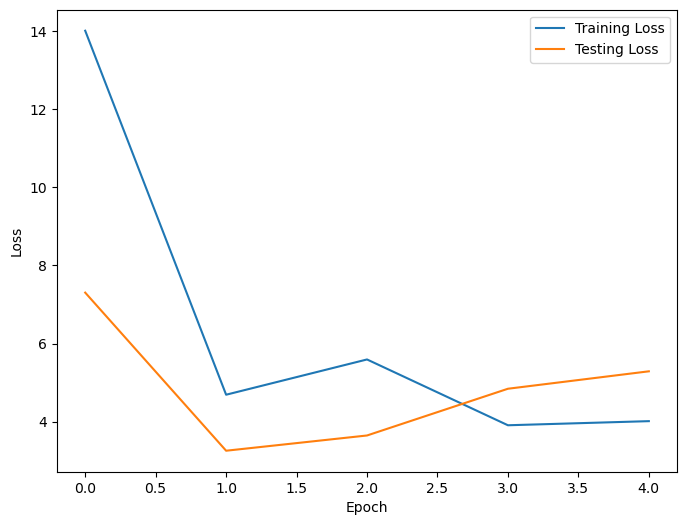

In [96]:
# Plot our train loss and test loss over epochs.
train_loss_efn = history_efn.history['loss']
test_loss_efn = history_efn.history['val_loss']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over the 5 epochs.
plt.plot(train_loss_efn, label='Training Loss')
plt.plot(test_loss_efn, label='Testing Loss')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

We can infer from the above loss plot that the training loss continues to drop with increasing epochs, while the testing loss drops until epoch=1, where it began to increase again. Also, the loss values are greater than 3, which means that this model is generally bad at minimizing loss.

From here, we can drop the EfficientNetB4 model as the model is not accurate and has a relatively high loss value.

# 6. Comparing CNN, MobileNetV2 and VGG19 models

In this section, we will view the accuracy and loss of each model in a table and combine the accuracy and loss graphs for some insights.

| Model | Train Accuracy | Test Accuracy | Train Loss | Test Loss |
| --------------- | --------------- | --------------- | --------------- | --------------- |
| CNN    | 0.9923    | 0.6626    | 0.0696 | 1.6319 |
| MobileNetV2 | 0.9392 | 0.8098 | 0.2255 | 0.5140 |
| VGG19 | 0.7710 | 0.6687 | 0.5937 | 0.8421 |

For CNN, the accuracy overfits by 0.33 and the loss overfits by 1.57.

For MobileNetV2, the accuracy overfits by 0.13 and the loss overfits by 0.29.

For VGG19, the accuracy overfits by 0.11 and the loss overfits by 0.25.

From here, we can see that the overfitting of our CNN model is the largest among the three models. Thus, we will not use the CNN model for future analysis. Comparing MobileNetV2 and VGG19, the accuracy difference and loss difference are close, although our VGG19 model overfits less. From here, we will plot the accuracy and loss over epochs.

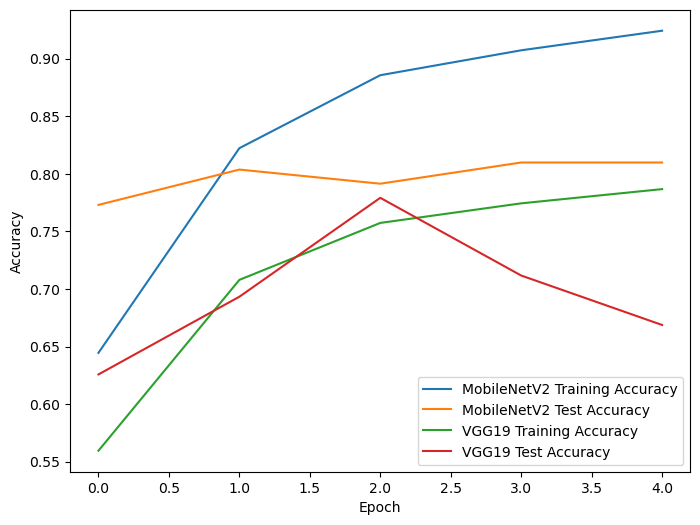

In [108]:
# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing accuracy over the epochs.
plt.plot(train_acc_mn, label='MobileNetV2 Training Accuracy')
plt.plot(test_acc_mn, label='MobileNetV2 Test Accuracy')
plt.plot(train_acc_vgg, label='VGG19 Training Accuracy')
plt.plot(test_acc_vgg, label='VGG19 Test Accuracy')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

From this accuracy plot, the accuracy scores for MobileNetV2 are much higher than that for VGG19. (Blue and Yellow lines are higher)

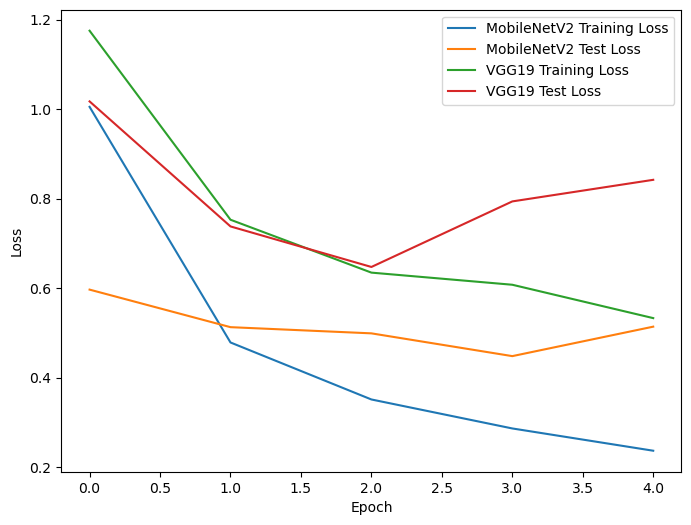

In [109]:
# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over the 5 epochs.
plt.plot(train_loss_mn, label='MobileNetV2 Training Loss')
plt.plot(test_loss_mn, label='MobileNetV2 Test Loss')
plt.plot(train_loss_vgg, label='VGG19 Training Loss')
plt.plot(test_loss_vgg, label='VGG19 Test Loss')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

From this loss plot, the loss for MobileNetV2 are much lower than that for VGG19. (Blue and Yellow lines are lower)

Therefore, we will choose our MobileNetV2 model for hypertuning in the next notebook. This is so that we can maximise accuracy and minimise loss for our unseen data.